In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

In [2]:
%load_ext autoreload
%autoreload 2 

project_dir = os.path.dirname(os.getcwd())
print('project direcotry is ', project_dir)
if project_dir not in sys.path:
    sys.path.append(project_dir)
print(sys.path)
#
pdb_dir = '/home/yuan/data/pdb/rsync'
data_dir = './data/'
outputs_dir = '/home/yuan/output/pdb_abag'

project direcotry is  /home/yuan/bio
['/home/yuan/anaconda3/envs/openfold-env/lib/python310.zip', '/home/yuan/anaconda3/envs/openfold-env/lib/python3.10', '/home/yuan/anaconda3/envs/openfold-env/lib/python3.10/lib-dynload', '', '/home/yuan/anaconda3/envs/openfold-env/lib/python3.10/site-packages', '/home/yuan/anaconda3/envs/openfold-env/lib/python3.10/site-packages/openfold-2.2.0-py3.10-linux-x86_64.egg', '/home/yuan/bio']


## 1. PDB 

### 1.1 AACDB

In [331]:
# download summary 
os.system(f"wget -c https://i.uestc.edu.cn/AACDB/data_zip/protein_table.txt -P {data_dir}")

--2025-05-13 08:22:42--  https://i.uestc.edu.cn/AACDB/data_zip/protein_table.txt
Resolving i.uestc.edu.cn (i.uestc.edu.cn)... 222.197.166.2, 2001:250:2000:71:222:197:166:2
Connecting to i.uestc.edu.cn (i.uestc.edu.cn)|222.197.166.2|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



0

In [18]:
infile = os.path.join(data_dir, 'protein_table.txt')
aacdb_summary = pd.read_csv(infile, sep='\t')
aacdb_summary.head(3)

,id,pdb,chains,antibody,INN(clinical_trial),ab_mutation,mutation,protein,targets,ag_mutation,mutation1,organism,method,resolution,reference
0,1,1A14,HL_N,NC10 Fv,NaN,No,NaN,NEURAMINIDASE,P03472,No,NaN,"Influenza A virus, Mus musculus",XRD,2.50,10.1006/jmbi.1998.1794
1,2,1A2Y,BA_C,D1.3 Fv,NaN,No,NaN,Lysozyme C,NaN,Yes,D18A,"Mus musculus, Gallus gallus",XRD,1.50,10.1021/bi980148j
2,3,1ADQ,HL_A,RF-AN Fab,NaN,No,NaN,IgG Fc,P01861;Q6PYX1;P01857;P01859,No,NaN,Homo sapiens,XRD,3.15,10.1038/nsb0597-374


In [270]:
def load_aacdb(aacdb_summary):
    aacdb = []
    for ix, row in aacdb_summary.iterrows():
        a, b = row['chains'].split('_')
        for _a in a:
            rec = {
                'pdb_id': row['pdb'],
                'model': 0,
                'chain_id': _a,
                'chain_type': 'antibody',
            }
            aacdb.append(rec)
        for _b in b:
            rec = {
                'pdb_id': row['pdb'],
                'model': 0,
                'chain_id': _b,
                'chain_type': 'antigen',
            }
            aacdb.append(rec)
    return pd.DataFrame(aacdb)

aacdb = load_aacdb(aacdb_summary)
aacdb.head()

,pdb_id,model,chain_id,chain_type
0,1A14,0,H,antibody
1,1A14,0,L,antibody
2,1A14,0,N,antigen
3,1A2Y,0,B,antibody
4,1A2Y,0,A,antibody


### 1.2 SAbDab

In [349]:
from src.dir import Dir

sabdab_raw, n = [], 0
file_iter = Dir('/home/yuan/data/sabdab/summary').recrusive_files()
for path in file_iter:
    if path.endswith('.tsv'):
        df = pd.read_csv(path, sep='\t')
        if len(df) > 0:
            sabdab_raw.append(df)
sabdab_raw = pd.concat(sabdab_raw, axis=0)
sabdab_raw['pdb'] = sabdab_raw['pdb'].str.upper()
sabdab_summary = sabdab_raw[~sabdab_raw['antigen_chain'].isna()]
# sabdab_summary = sabdab_summary[~(sabdab_summary['antigen_type']=='Hapten')]
# sabdab_summary[(sabdab_summary['Hchain'].isna()) & (sabdab_summary['Lchain'].isna())]
print(sabdab_summary.shape)
sabdab_summary.head()

(14486, 30)


,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
0,3WHX,A,B,0,B,Hapten,XPG,"7-[(1R,3R)-3-hydroxy-2-[(1E,3S)-3-hydroxyoct-1...",IMMUNE SYSTEM,09/03/13,...,False,False,IGHV1,IGKV1,Kappa,NaN,NaN,NaN,NaN,NaN
0,8CYB,D,NaN,0,A,protein,NaN,spike glycoprotein,VIRAL PROTEIN,07/06/22,...,False,True,IGHV1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,1NSN,H,L,0,S,protein,NaN,staphylococcal nuclease,COMPLEX (IMMUNOGLOBULIN/HYDROLASE),06/06/95,...,False,False,IGHV3,IGKV3,Kappa,1.000000e-10,-13.63,Other,NaN,1704035.0
0,7TRK,H,h,0,A | B,protein | protein,NA | NA,guanine nucleotide-binding protein g(i) subuni...,SIGNALING PROTEIN/IMMUNE SYSTEM,05/17/23,...,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN
0,1R3L,B,A,0,C,protein,NaN,voltage-gated potassium channel,MEMBRANE PROTEIN,10/02/03,...,False,False,IGHV1,IGKV5,Kappa,NaN,NaN,NaN,NaN,NaN


In [354]:
sabdab_summary['pdb']

0    3WHX
0    8CYB
0    1NSN
0    7TRK
0    1R3L
     ... 
1    1E4X
0    5WN9
0    8IJB
0    4WUU
0    7X2I
Name: pdb, Length: 14486, dtype: object

In [121]:
cols = ['pdb_id', 'model',  'chain_id']

df1 = sabdab_summary[['pdb', 'model', 'Hchain']]
df1.columns = cols
df1 = df1[~df1['chain_id'].isna()]
df1 = df1.assign(chain_type = 'heavy')

df2 = sabdab_summary[['pdb','model','Lchain']]
df2.columns = cols
df2 = df2[~df2['chain_id'].isna()]
df2 = df2.assign(chain_type = 'light')


df3 = sabdab_summary[['pdb','model','antigen_chain']]
df3.columns = cols
df3 = df3.assign(chain_type = 'receptor')

# concatenate
sabdab = pd.concat([df1, df2, df3])
sabdab = sabdab.sort_values(cols)
print(sabdab.shape)
sabdab.head()

(40361, 4)


,pdb_id,model,chain_id,chain_type
0,1A14,0,H,heavy
0,1A14,0,L,light
0,1A14,0,N,receptor
0,1A2Y,0,A,light
0,1A2Y,0,B,heavy


In [122]:
sabdab = sabdab.drop_duplicates()
print(sabdab.shape, sabdab.dtypes)
print(sabdab.head())

(39336, 4) pdb_id        object
model          int64
chain_id      object
chain_type    object
dtype: object
  pdb_id  model chain_id chain_type
0   1A14      0        H      heavy
0   1A14      0        L      light
0   1A14      0        N   receptor
0   1A2Y      0        A      light
0   1A2Y      0        B      heavy


In [124]:
sabdab_summary['antigen_type'].value_counts()

antigen_type
protein                                            10201
protein | protein                                   1722
peptide                                             1346
Hapten                                               493
protein | protein | protein                          233
carbohydrate                                         206
protein | peptide                                    105
nucleic-acid                                          76
peptide | protein                                     18
peptide | peptide                                     16
protein | protein | protein | protein                 15
unknown                                               13
protein | protein | peptide                           11
protein | protein | protein | protein | protein        8
protein | nucleic-acid                                 3
peptide | protein | protein                            3
nucleic-acid | nucleic-acid                            3
protein | peptide 

In [74]:
# antigen is antibody
sabdab_summary[sabdab_summary['pdb']=='1A8J']

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
0,1A8J,NaN,L,0,L,Hapten,PME,N-L-ALPHA-ASPARTYL L-PHENYLALANINE 1-METHYL ESTER,IMMUNOGLOBULIN,03/26/98,...,False,False,NaN,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN
1,1A8J,NaN,H,0,L,Hapten,PME,N-L-ALPHA-ASPARTYL L-PHENYLALANINE 1-METHYL ESTER,IMMUNOGLOBULIN,03/26/98,...,False,False,NaN,IGLV2,Lambda,NaN,NaN,NaN,NaN,NaN


In [75]:
# example of complex that is not covered by sabdab
sabdab_raw[sabdab_raw['pdb']=="9B6T"]

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
0,9B6T,H,L,0,C | D | B | F,protein | protein | protein | protein,NA | NA | NA | NA,capsid protein vp1 | capsid protein vp1 | caps...,VIRAL PROTEIN/IMMUNE SYSTEM,04/16/25,...,False,True,IGHV4,IGLV1,Lambda,NaN,NaN,NaN,NaN,NaN


In [76]:
# only one chain, antigen is small molecule
sabdab_raw[sabdab_raw['pdb']=="3GM0"]

,pdb,Hchain,Lchain,model,antigen_chain,antigen_type,antigen_het_name,antigen_name,short_header,date,...,scfv,engineered,heavy_subclass,light_subclass,light_ctype,affinity,delta_g,affinity_method,temperature,pmid
0,3GM0,a,A,0,A,Hapten,B41,"(2S)-1-(1,3-BENZODIOXOL-5-YL)-N-METHYLPROPAN-2...",IMMUNE SYSTEM,03/12/09,...,True,True,unknown,unknown,unknown,NaN,NaN,NaN,NaN,NaN


### 1.3 IEDB

In [267]:
# pip install mysql-connector-python
import mysql.connector
def load_iedb():
    config = {
        'host': 'localhost',
        'user': 'admin',
        'password': 'strong_password',
        'database': 'IEDB'
    }
    try:
        connection = mysql.connector.connect(**config)
        cursor = connection.cursor(dictionary=True)
        query = """
            SELECT pdb_id, complex_type
            FROM complex
            WHERE complex_type NOT IN ('alphabeta', 'I', 'II', 'non classical', 'IgNAR')
        """
        cursor.execute(query)
        rows = cursor.fetchall()
        df = pd.DataFrame(rows)
        return df
    except Exception as e:
        print(f"Error: {e}")
    finally:
        if 'connection' in locals() and connection.is_connected():
            cursor.close()
            connection.close()

iedb = load_iedb()
iedb.head()

,pdb_id,complex_type
0,2OTU,heavylight
1,2OTW,heavylight
2,3JCB,heavylight
3,5TUD,heavylight
4,6LXJ,construct


In [256]:
iedb.groupby('complex_type').agg(len).sort_values('pdb_id', ascending=False)

,pdb_id
complex_type,
heavylight,1885
construct,1738
heavy,671
scFv,206
lightlight,20
light,13
beta,5
gammadelta,4
TscFv,1


In [ ]:
### abYbank
http://www.abybank.org/abdb/

In [313]:
import requests
from bs4 import BeautifulSoup

def parse_pdb_id(res):
    soup = BeautifulSoup(res.text, 'html.parser')
    pdb_ids = []
    for line in soup.find_all('a'):
        pdb_id = re.findall(r'>(.*)_\d.pdb', str(line))
        if pdb_id:
            pdb_ids.extend(pdb_id)
    return pdb_ids

abYbank_pdb = []
url = 'http://www.abybank.org/abdb/Data'
for chain in ('LH', 'L', 'H'):
    for numbering in ('Kabat', 'Chothia', 'Martin'):
        endpoint = f"{url}/{chain}_Combined_{numbering}/"
        print(endpoint)
        res = requests.get(endpoint)
        abYbank_pdb.extend(parse_pdb_id(res))
abYbank_pdb = list(set(abYbank_pdb))
print(len(abYbank_pdb), abYbank_pdb[:10])

http://www.abybank.org/abdb/Data/LH_Combined_Kabat/
http://www.abybank.org/abdb/Data/LH_Combined_Chothia/
http://www.abybank.org/abdb/Data/LH_Combined_Martin/
http://www.abybank.org/abdb/Data/L_Combined_Kabat/
http://www.abybank.org/abdb/Data/L_Combined_Chothia/
http://www.abybank.org/abdb/Data/L_Combined_Martin/
http://www.abybank.org/abdb/Data/H_Combined_Kabat/
http://www.abybank.org/abdb/Data/H_Combined_Chothia/
http://www.abybank.org/abdb/Data/H_Combined_Martin/
3348 ['6FN4', '4MHJ', '1FBI', '1PZ5', '4YHZ', '1DBM', '1KYO', '3X3F', '1C5C', '4XX1']


### 1.5 this study

In [325]:
# pdb files in this study
from src.collect import Collect

def load_abag():
    abag_chains = []
    meta_iter = Collect('/home/yuan/output/pdb_abag').meta()
    for _data in meta_iter:
        abag_chains.extend(_data)
    abag_chains = pd.concat(abag_chains, axis=0)
    abag_chains = abag_chains[['pdb_id', 'model',  'chain_id', 'chain_type']]
    abag_chains = abag_chains.drop_duplicates()
    print(abag_chains.shape)
    return abag_chains
   
abag = load_abag()

(212888, 4)
  pdb_id  model chain_id chain_type
0   9FNS      0        A    antigen
1   9FNS      0        B    antigen
2   9FNS      0        C      heavy
3   9FNS      0        D      light
4   9FNS      0        E      heavy


## compare pdb_id

### Venn

In [323]:
# check any pdb_ids which are not covered by the results of this study but in SAbDab 
# reason: some structures havenot coordinate files
# SAbDab
sabdab_pdb = sabdab['pdb_id'].dropna().unique()
print('SAbDab', len(sabdab_pdb), sabdab_pdb)

# AACDB
aacdb_pdb = aacdb['pdb_id'].dropna().unique()
print('AACDB', len(aacdb_pdb), aacdb_pdb)

# IEDB
iedb_pdb = iedb['pdb_id'].dropna().unique()
print('IEDB', len(iedb_pdb), iedb_pdb)

# abYbank
abYbank_pdb = list(set(abYbank_pdb))
print('abYbank', len(abYbank_pdb), abYbank_pdb[:10])

# this study
abag_pdb = abag['pdb_id'].dropna().unique()
print('this study:', len(abag_pdb), abag_pdb)

SAbDab 7632 ['1A14' '1A2Y' '1A3L' ... '9MYL' '9UA9' '9UAA']
AACDB 3674 ['1A14' '1A2Y' '1ADQ' ... '6OKN' '6SGE' '6V7Y']
IEDB 4110 ['2OTU' '2OTW' '3JCB' ... '3HNV' '1IKF' '1IBG']
abYbank 3348 ['6FN4', '4MHJ', '1FBI', '1PZ5', '4YHZ', '1DBM', '1KYO', '3X3F', '1C5C', '4XX1']
this study: 25928 ['9FNS' '9FZD' '9FSE' ... '118L' '119L' '113L']


<Figure size 1600x800 with 0 Axes>

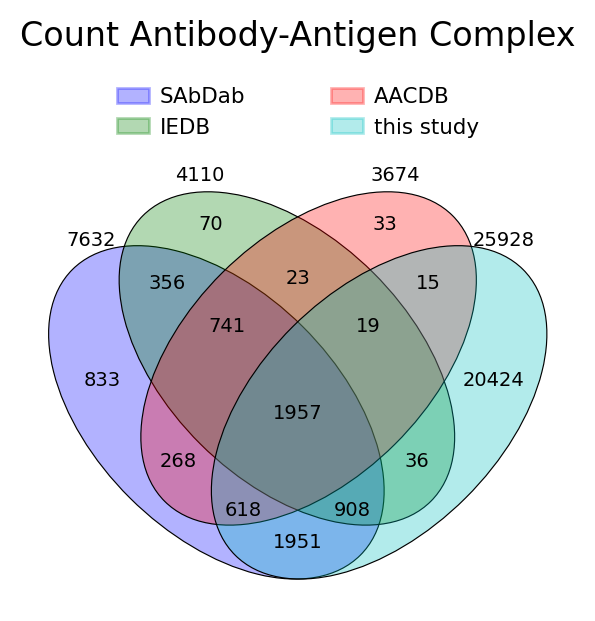

In [322]:
from venny4py.venny4py import *

sets = {
    'SAbDab': set(sabdab_pdb),
    'IEDB': set(iedb_pdb), 
    # 'abYbank': set(abYbank_pdb),
    'AACDB': set(aacdb_pdb),
    'this study': set(abag_pdb),
}
plt.figure(figsize=(8,4))
venny4py(sets=sets)
plt.title('Count Antibody-Antigen Complex')
plt.show()

In [284]:
# set(iedb_pdb).difference(set(abag_pdb))

### this study vs SAbDab

In [289]:
from src.collect import Collect
from src.parse_abag import ParseAbAg

def pdb_difference(abag, other):
    abag_pdb = abag['pdb_id'].unique()
    exclude = [
        # those pdb failed due to bugging of freesasa
        '1OAX', '1OAU', '4CAU',
        # particle
        '7DST', '7DSS',
        # non antibody complex
        '4QKX', '6YO6', '7KI1', '7KI0', '6WPW', '3KS0',
        '4KSD', '6O3C', '6A96', '5O1R', '4Y7M', '4H0I',
        '3K1K', '3EBA','5EUL', '4MQX', '6HUG', '6HUP',
        '6HUK', '6HUJ','6HUO','3MUH','6JSZ', '3P9W',
        '7D5B', '7D5U', '7WXW','9J3O','7N4N','8JGG',
        '8G8W','7RUG','7F1G','8J24','9J3N','9FZQ','4PJ9',
        '7Y89','',
    ]
    print('this study exclude some pdb:', len(exclude))
    
    pdb_pool, n = [], 0
    other_pdb = other['pdb_id'].dropna().unique()
    for a in other_pdb:
        if a in abag_pdb:
            n += 1
        else:
            if a not in exclude:
                pdb_pool.append(a)
    print('not covered by this study:', len(pdb_pool), pdb_pool[:10])
    print('intersection between this study and the other database:', n)
    return pdb_pool

def view_difference(pdb_pool):
    # check if raw pdb files exist in this study. If so, print them
    pdb_dir = '/home/yuan/data/pdb/rsync'
    # pdb_dir = '/home/yuan/data/ftp.ebi.ac.uk'
    raw_iter = Collect(pdb_dir).get_raw_pdb()
    n = {}
    for pdb_id, path in raw_iter:
        if pdb_id in n:
            print(pdb_id, n[pdb_id], path)
        else:
            n[pdb_id] = path
        if pdb_id in pdb_pool:
            p = ParseAbAg(path)
            pprint(p.structure.header['compound'])
            print('---'*10)
    print(len(n))
    
    # export unpresented pdb for execute the pipeline again
    print('unknown pdb:', len(pdb_pool))
    n = 0
    if pdb_pool:
        with open('scripts/extra_pdb.txt', 'w') as f:
            raw_iter = Collect(pdb_dir).get_raw_pdb()
            for pdb_id, path in raw_iter:
                if pdb_id in pdb_pool:
                    # print(pdb_id, path)
                    f.write(path + '\n')
                    n += 1
    print(f'export pdb path ready for run.py: {n}')

In [291]:
# this study vs sabdab
abag = load_abag()
pdb_pool = pdb_difference(abag, sabdab)
# view_difference(pdb_pool)

this study exclude some pdb: 44
not covered by this study: 2167 ['1A3L', '1A3R', '1A6V', '1A6W', '1A8J', '1AXS', '1BQL', '1C5C', '1CBV', '1CE1']
intersection between this study and the other database: 5434
Successfully retrieve structure of 4Z5R
{'1': {'chain': 'd, e, f, g, h, i, x, n',
       'engineered': 'yes',
       'misc': '',
       'molecule': 'interferon alpha-2',
       'synonym': 'ifn-alpha-2,interferon alpha-a,leif a'},
 '2': {'chain': 'j, l, v, p, r, t, y, a',
       'engineered': 'yes',
       'misc': '',
       'molecule': 'anti-ifn-a antibody rontalizumab light chain'},
 '3': {'chain': 'k, m, w, q, s, u, z, b',
       'engineered': 'yes',
       'misc': '',
       'molecule': 'anti-ifn-a antibody rontalizumab heavy chain modules vh '
                   'andch1 (fab) '}}
------------------------------
Successfully retrieve structure of 7ZKW
{'1': {'chain': 'a, b',
       'engineered': 'yes',
       'misc': '',
       'molecule': 'cystinosin homolog'},
 '2': {'chain': 'c,

KeyboardInterrupt: 

In [287]:
# this study vs IEDB
abag = load_abag()
pdb_pool = pdb_difference(abag, iedb)
# view_difference(pdb_pool)

this study exclude some pdb: 44
not covered by this study: 1445 ['3WHE', '4P59', '6U02', '6QGX', '6QGY', '6QGW', '6LPB', '6PBV', '6PBW', '6VI4']
intersection between this study and the other database: 2651


In [290]:
# this study vs AACDB
abag = load_abag()
pdb_pool = pdb_difference(abag, aacdb)
# view_difference(pdb_pool)

this study exclude some pdb: 44
not covered by this study: 2600 ['1A14', '1ADQ', '1AFV', '1BQL', '1BVK', '1CZ8', '1DQJ', '1DVF', '1DZB', '1EZV']
intersection between this study and the other database: 1067


In [70]:
import re
re.findall(r'^ig (?:lambda|kappa|gamma)', 'ig lambda chain v-ii region mgc')

['ig lambda']

### example of excluded

## confirm pdb that are not covered by other DB

In [22]:
other_db = np.concatenate([sabdab_pdb, aacdb_pdb])
abag_unique = list(set(abag_pdb).difference(set(other_db)))
print(len(abag_unique), abag_unique[:10])

4488 ['8P8A', '1DUY', '3QW7', '8UHS', '8YWX', '7W55', '7TXT', '8G8N', '3QTO', '2Y5F']


In [71]:
# confirm complex only detected by this study in the json file 
from src.parse_abag import ParseAbAg
import json
from datetime import datetime

n = 0
res = {}
pdb_dir = '/home/yuan/data/pdb/rsync'
raw_iter = Collect(pdb_dir).filter_raw_pdb(abag_unique)
for pdb_id, path in raw_iter:
    n += 1
    p = ParseAbAg(path, None, False)
    p.filter_antibody_antigen(outputs_dir)
    complex = p.complex
    this_type = complex.get('complex_type', 'other')
    if this_type not in res:
        res[this_type] = []
    res[this_type].append(complex)
    # if n >=100:
    #     break
print(f'total raw: {n}')

for _type, _data in res.items():
    _data = sorted(_data, key=lambda x: datetime.strptime(x['release_date'], '%Y-%m-%d'), reverse=True)
    outfile = f"./data/check/{_type}.json"
    with open(outfile, 'w') as f:
        json.dump(_data, f, indent=4)
    print(f"complex type={_type}, num={len(_data)}")

total raw: 4488
complex type=antibody_antibody, num=1494
complex type=heavy-light-antibody_antigen, num=1897
complex type=other, num=366
complex type=single-domain-antibody_antigen, num=731


In [59]:
[i['release_date'] for i in _data]

['2024-04-17',
 '2022-06-29',
 '2022-06-29',
 '2022-10-19',
 '2022-10-19',
 '2022-10-19',
 '2024-11-20',
 '2024-11-20']

In [281]:
import re
pattern = '|'.join(['jl[a-z]-[a-z]\d+', ])
re.findall(pattern, 'maltose-bindmaing cproxxperiplasmicjla-g9 protein cia1d7 cia0')

['jla-g9']

In [179]:
cols = ['pdb_id', 'chain_id']
abag_sabdab1 = pd.merge(abag_chains, sabdab, on=cols, how='left')
print(abag_sabdab1.shape)
abag_sabdab2 = pd.merge(abag_chains, sabdab, on=cols, how='inner')
print(abag_sabdab2.shape)
abag_sabdab3 = pd.merge(abag_chains, sabdab, on=cols, how='right')
print(abag_sabdab3.shape)

(50300, 6)
(14148, 6)
(20735, 6)


In [180]:
abag_sabdab3

,pdb_id,model_x,chain_id,chain_type_x,model_y,chain_type_y
0,1A14,0.0,H,heavy,0,heavy
1,1A14,0.0,L,light,0,light
2,1A14,0.0,N,receptor,0,receptor
3,1A2Y,0.0,A,light,0,light
4,1A2Y,0.0,B,heavy,0,heavy
...,...,...,...,...,...,...
20730,NaN,NaN,L,NaN,0,receptor
20731,NaN,NaN,N,NaN,0,heavy
20732,NaN,NaN,N,NaN,0,receptor
20733,NaN,NaN,P,NaN,0,receptor


In [128]:
sabdab_chains[sabdab_chains['pdb_id']=='9FGS']

,pdb_id,model,chain_id,chain_type
